#### Preamble and basic imports

Note that this notebook depends on an external library, [dysts](https://github.com/williamgilpin/dysts), which contains implementations of more than one hundred different chaotic dynamical systems

In [99]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
# from numba import jit

from utils import *
#from benchmark_utils import print_dict, score_ts

from models import *


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# import signal

# class TimeoutException(Exception):   # Custom exception class
#     pass

# def timeout_handler(signum, frame):   # Custom signal handler
#     raise TimeoutException

# # Change the behavior of SIGALRM
# signal.signal(signal.SIGALRM, timeout_handler)
# timeout_flag = True
# for i in range(3):
#     # Start the timer. Once 5 seconds are over, a SIGALRM signal is sent.
#     signal.alarm(1)    
#     # This try/except loop ensures that 
#     #   you'll catch TimeoutException when it's sent.
#     try:
#         sol = solve_ivp(skew_rhs, [0, 200], all_ic, t_eval=np.linspace(0, 200, 2000))
#         timeout_flag = False
#     except TimeoutException:
#         continue # continue the for loop if function A takes more than 5 second
#     else:
#         # Reset the alarm
#         signal.alarm(0)

# print(timeout_flag)

NameError: name 'solve_ivp' is not defined

: 

In [3]:
# from dysts.base import get_attractor_list
# from dysts.utils import integrate_dyn
# import dysts.flows
# from dysts.flows import *

# from dysts.analysis import sample_initial_conditions

# from scipy.integrate import solve_ivp

# mr = 60 # number of response systems

all_system_names

['Aizawa',
 'AnishchenkoAstakhov',
 'Arneodo',
 'ArnoldBeltramiChildress',
 'ArnoldWeb',
 'BeerRNN',
 'BelousovZhabotinsky',
 'BickleyJet',
 'Blasius',
 'BlinkingRotlet',
 'BlinkingVortex',
 'Bouali',
 'Bouali2',
 'BurkeShaw',
 'CaTwoPlus',
 'CaTwoPlusQuasiperiodic',
 'CellCycle',
 'CellularNeuralNetwork',
 'Chen',
 'ChenLee',
 'Chua',
 'CircadianRhythm',
 'CoevolvingPredatorPrey',
 'Colpitts',
 'Coullet',
 'Dadras',
 'DequanLi',
 'DoubleGyre',
 'DoublePendulum',
 'Duffing',
 'ExcitableCell',
 'Finance',
 'FluidTrampoline',
 'ForcedBrusselator',
 'ForcedFitzHughNagumo',
 'ForcedVanDerPol',
 'GenesioTesi',
 'GuckenheimerHolmes',
 'Hadley',
 'Halvorsen',
 'HastingsPowell',
 'HenonHeiles',
 'HindmarshRose',
 'Hopfield',
 'HyperBao',
 'HyperCai',
 'HyperJha',
 'HyperLorenz',
 'HyperLu',
 'HyperPang',
 'HyperQi',
 'HyperRossler',
 'HyperWang',
 'HyperXu',
 'HyperYan',
 'HyperYangChen',
 'IkedaDelay',
 'IsothermalChemical',
 'ItikBanksTumor',
 'JerkCircuit',
 'KawczynskiStrizhak',
 'Laser',


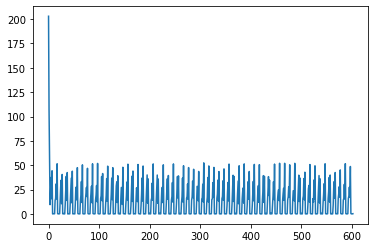

In [20]:
ic.shape

(10,)

In [19]:
Lorenz().dt




from dysts.utils import integrate_dyn


# upscale_factor = (tlim / self.dt) / n
# if upscale_factor > 1e3:
#     warnings.warn(
#         f"Expect slowdown due to excessive integration required; scale factor {upscale_factor}"
#     )



tpts = np.arange(0, 2000) *  min(eq_driver.dt, eq_response.dt)
n = 2000
pts_per_period = 30
# tlim = min(eq_driver.period, eq_response.period) * (n / pts_per_period)
# tvals = np.linspace(0, tlim, n)

# dt = min(eq_driver.dt, eq_response.dt)
# ff = lambda x, y : skew_rhs(y, x)
# integrate_dyn(ff, ic, tvals, dtval=dt, method="Radau")



ValueError: operands could not be broadcast together with shapes (7,) (600,) (7,) 

In [100]:
from dysts.base import get_attractor_list
from dysts.utils import integrate_dyn
import dysts.flows
from dysts.flows import *

from dysts.analysis import sample_initial_conditions

from models import RecurrenceManifold

from scipy.integrate import solve_ivp

mr = 60 # number of response systems

all_system_names = get_attractor_list()
# np.random.seed(0)
# np.random.shuffle(all_system_names)
# # all_system_names = all_system_names
# np.random.seed(0)
# np.random.shuffle(all_system_names)

import time
# timeout variable can be omitted, if you use specific value in the while condition
timeout = 1000   # [seconds]


# all_system_name_pairs = list(itertools.product(all_system_names, all_system_names))
# np.random.seed(0)
# np.random.shuffle(all_system_name_pairs)
# for driver_name, response_name in all_system_name_pairs:

# np.random.seed(0)
for i in range(100):
    driver_name, response_name = np.random.choice(all_system_names, 2, replace=False)
    if driver_name == response_name:
        print("Skipping pair of identical DS", flush=True)
        continue

    print(driver_name, response_name, flush=True)
    eq_driver = getattr(dysts.flows, driver_name)()
    eq_response = getattr(dysts.flows, response_name)()
    nd, nr = len(eq_driver.ic), len(eq_response.ic)

    if (nd > 5) or (nr > 5):
        print("Skipping large DS", flush=True)
        continue

    sol_driver_pure = eq_driver.make_trajectory(1000)
    sol_response_pure = eq_response.make_trajectory(1000)
    amp_drive = np.mean(np.abs(sol_driver_pure), axis=0)
    amp_response = np.mean(np.abs(sol_response_pure), axis=0)


    ic_vals = sample_initial_conditions(eq_response, mr)

    all_rhs = list()
    for ic in ic_vals:
        ds = getattr(dysts.flows, eq_response.name)()
        ds.ic = ic
        all_rhs.append(ds.rhs)

    def skew_rhs(t, X, kappa=1e-2):
        Xd, Xr = X[:nd], X[nd:]
        
        Xr += kappa * Xd[0] * (np.tile(amp_response, mr) / amp_drive[0]) # drive with first variable. Scales by typical amplitude

        drive_out = eq_driver(Xd, t)
        all_out = list()
        for i, rhs in enumerate(all_rhs):
            rhs_out = rhs(Xr[(i*nr):((i + 1) * nr)], t)
            all_out.append(rhs_out)
        all_out = [drive_out] + all_out
        out = np.concatenate(all_out)

        return out

    all_ic = np.concatenate([np.array(eq_driver.ic), np.ravel(ic_vals)])        
    
    #tpts = np.linspace(0, 50, 2000)
    #sol = solve_ivp(skew_rhs, [0, 50], all_ic, t_eval=tpts, method="Radau")


    dt = min(eq_driver.dt, eq_response.dt)
    dt *= min(max(eq_driver.dt / dt, eq_response.dt / dt), 100) # bound the slowest step
    #dt = eq_driver.dt
    tlim = 5 * eq_driver.period
    tpts = np.linspace(0, tlim, 2000)
    sol = solve_ivp(skew_rhs, [0, tlim], all_ic, t_eval=tpts, first_step=dt)
    
    sol_drive = sol.y[:nd]
    sol_response = sol.y[nd:]#[::nr]

    if sol_response.shape[1] < len(tpts):
        print(f"Incomplete solution {sol_response.shape}", flush=True)
        continue


    model = RecurrenceManifold(random_state=0, scale=np.log(2))
    label_vals0 = model.fit_predict(sol_response.T)

    true_and_recon = np.vstack([sol_drive[0], label_vals0]).T


    measures_driver = [
        eq_driver.maximum_lyapunov_estimated,
        eq_driver.multiscale_entropy,
        eq_driver.correlation_dimension,
        eq_driver.kaplan_yorke_dimension
    ]


    measures_response = [
        eq_response.maximum_lyapunov_estimated,
        eq_response.multiscale_entropy,
        eq_response.correlation_dimension,
        eq_response.kaplan_yorke_dimension
    ]

    dr_str = "driver_" + "|".join([str(item) for item in measures_driver])
    resp_str = "response_" + "|".join([str(item) for item in measures_response])
    np.savetxt( "response_" + driver_name + "_X_" + response_name + "_" + dr_str + "_" + resp_str + ".txt",  true_and_recon)

    


SprottK DoublePendulum


/Users/williamgilpin/miniconda3/envs/shrec/lib/python3.8/site-packages/dysts/base.py:255: UserWarning: This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.
  warnings.warn(


KeyboardInterrupt: 

In [78]:
import multiprocessing
import time


p = multiprocessing.Process(
    target=solve_ivp,
    name="integration", 
    args=(skew_rhs, [0, tlim], all_ic), 
    kwargs={"t_eval": tpts, "first_step": dt}
    )
p.start()

# Wait 10 seconds for foo
time.sleep(10)


# If thread is active
if p.is_alive():
    print("Terminating active prpocess")

    # Terminate foo
    p.terminate()
    p.join()


# multiprocessing.Process(target=foo, args=(), kwargs={})


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/williamgilpin/miniconda3/envs/shrec/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/williamgilpin/miniconda3/envs/shrec/lib/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'skew_rhs' on <module '__main__' (built-in)>


In [103]:
import glob
from benchmark_utils import print_dict, score_ts

all_results = sorted(glob.glob("private_dump/*.txt"))

all_scores1, all_scores2, all_scores3 = list(), list(), list()
all_lyap1, all_lyap2 = list(), list()
for result_str in all_results:
    data = np.loadtxt(result_str)
    print(data[:, 0].shape, data[:, 1].shape, flush=True)
    if len(data) < 1000:
        continue

    all_lyap1.append(float(result_str.split("driver")[1].split("_")[1].split("|")[0]))
    all_lyap2.append(float(result_str.split("response")[2].split("_")[1].split("|")[0]))

    scores = score_ts(standardize_ts(data[:, 0]), standardize_ts(data[:, 1]))
    all_scores1.append(scores["mutual_info"])
    all_scores2.append(scores["cross forecast error neural 2"])
    all_scores3.append(scores["dynamic time warping distance"])


(2000,) (2000,)
(2000,) (2000,)
(2000,) (2000,)
(2000,) (2000,)
(2000,) (2000,)
(15,) (15,)
(2000,) (2000,)
(2000,) (2000,)
(2000,) (2000,)
(2000,) (2000,)
(2000,) (2000,)
(2000,) (2000,)
(2000,) (2000,)
(2000,) (2000,)
(2000,) (2000,)
(2000,) (2000,)
(2000,) (2000,)
(2000,) (2000,)
(2000,) (2000,)
(2000,) (2000,)


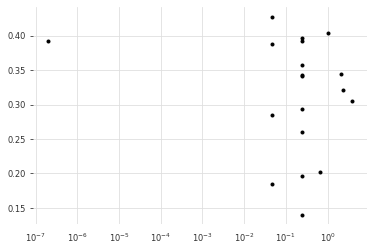

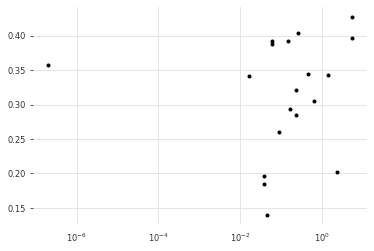

In [106]:
plt.figure()
plt.semilogx(all_lyap1, all_scores3, ".")


plt.figure()
plt.semilogx(all_lyap2, all_scores3, ".")

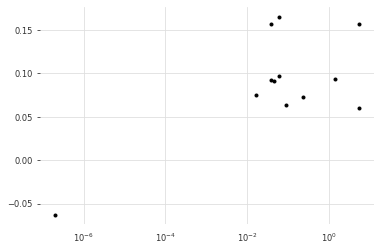

In [41]:
plt.semilogx(all_lyap2, all_scores1, ".")

In [2]:
import dysts.flows

from dysts.flows import *

mr = 60 # number of response systems

# driver system

# response system
# random initial conditions
# how to couple in driver?]

eq_driver = Rossler()
eq_response = Lorenz()

sol_driver_pure = eq_driver.make_trajectory(1000)
sol_response_pure = eq_response.make_trajectory(1000)
amp_drive = np.mean(np.abs(sol_driver_pure), axis=0)
amp_response = np.mean(np.abs(sol_response_pure), axis=0)

from dysts.utils import integrate_dyn

nd = len(eq_driver.ic)
nr = len(eq_response.ic)


# X

# integrate_dyn


In [30]:
from dysts.analysis import sample_initial_conditions
from benchmark_utils import print_dict, score_ts

ic_vals = sample_initial_conditions(eq_response, mr)

all_rhs = list()
for ic in ic_vals:
    ds = getattr(dysts.flows, eq_response.name)()
    ds.ic = ic
    all_rhs.append(ds.rhs)

def skew_rhs(t, X, kappa=1e-2):
    Xd, Xr = X[:nd], X[nd:]
    
    Xr += kappa * Xd[0] * (np.tile(amp_response, mr) / amp_drive[0]) # drive with first variable. Scales by typical amplitude

    drive_out = eq_driver(Xd, t)
    all_out = list()
    for i, rhs in enumerate(all_rhs):
        rhs_out = rhs(Xr[(i*nr):((i + 1) * nr)], t)
        all_out.append(rhs_out)
    all_out = [drive_out] + all_out
    out = np.concatenate(all_out)

    return out

all_ic = np.concatenate([np.array(eq_driver.ic), np.ravel(ic_vals)])

# out_ex = skew_rhs(0, all_ic)



/Users/williamgilpin/miniconda3/envs/shrec/lib/python3.8/site-packages/dysts/base.py:232: UserWarning: Expect slowdown due to excessive integration required; scale factor 1587.2891671013736
  warnings.warn(


In [1]:
from scipy.integrate import solve_ivp

sol = solve_ivp(skew_rhs, [0, 50], all_ic, t_eval=np.linspace(0, 50, 2000))
sol_drive = sol.y[:nd]
sol_response = sol.y[nd:]#[::nr]


plt.figure()
plt.plot(sol_drive[0], sol_drive[1])

plt.figure()
plt.plot(sol_response[0], sol_response[1])

# heatplot: driver lyapunov, response lyapunov, accuracy score



## reconstruct signal

model = RecurrenceManifold(random_state=0, scale=np.log(2))
label_vals0 = model.fit_predict(sol_response.T)

plt.figure()
plt.plot(label_vals0)

plt.figure()
plt.plot(sol_drive[0])


plt.figure()
plt.plot(label_vals0, sol_drive[0], '.')


print(scipy.stats.spearmanr(label_vals0, sol_drive[0]).correlation)


from benchmark_utils import print_dict, score_ts
print_dict(score_ts(label_vals0, sol_drive[0]))


NameError: name 'skew_rhs' is not defined

In [198]:

0.01 mutual_info
2.94 conditional_info
-0.52 conditional_info_back
4.85 mae
8156.47 mape
607.59 marre
31.19 mse
-1403.42 r2_score
5.58 rmse
186.08 smape
0.02 spearman
0.01 pearson
0.01 kendalltau
0.37 sync
0.05 coherence
0.08 coherence_phase
0.01 cross forecast error
0.1 cross forecast error neural
0.05 cross forecast error neural 2


0.09 mutual_info # good
3.05 conditional_info # meh
-0.84 conditional_info_back  # bad
4.85 mae
23438.65 mape # good
958.94 marre
31.14 mse
-2716.27 r2_score
5.58 rmse
191.72 smape # bad
-0.09 spearman
-0.04 pearson
-0.07 kendalltau
0.48 sync # ok
0.08 coherence
0.96 coherence_phase # good
0.1 cross forecast error # meh
0.19 cross forecast error neural # good
0.39 cross forecast error neural 2 # good


-0.1707540816885204
0.23 mutual_info # good
2.71 conditional_info
-1.01 conditional_info_back
4.86 mae
11036.05 mape
672.16 marre
31.03 mse
-1411.29 r2_score
5.57 rmse
189.66 smape
-0.17 spearman
0.08 pearson
-0.22 kendalltau
0.47 sync # hmm
0.11 coherence
0.96 coherence_phase # hmm
0.38 cross forecast error # hmm
0.08 cross forecast error neural # hmm
0.55 cross forecast error neural 2 # good


-0.08919369811777685

In [109]:
# vals_response = X_measure.T
true_data =  X_measure.T
true_driver0 = sol_drive[:, 0].T

from sklearn.decomposition import PCA
embedding = PCA()
pca_vals = embedding.fit_transform(true_data)[:, 0]


model = RecurrenceManifold(random_state=0, scale=np.log(2))

curr_time()
label_vals0 = model.fit_predict(true_data)
curr_time()


plt.figure()
plt.plot(pca_vals, 'k')
plt.title("PCA")

plt.figure()
plt.plot(label_vals0, 'k')
plt.title("Labels")

plt.figure()
plt.plot(true_driver0, 'k')
plt.title("true")

plt.figure()
plt.plot(true_driver0, label_vals0, '.k', markersize=2)
plt.title("Labels vs True")


plt.figure()
plt.plot(true_driver0, pca_vals, '.k', markersize=2)
plt.title("PCA vs True")


NameError: name 'X_measure' is not defined

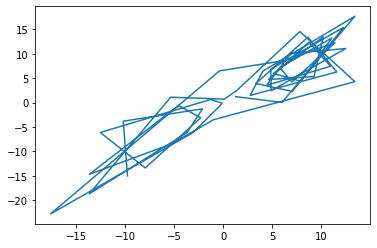

In [52]:
plt.plot

In [30]:
np.array(eq_driver.ic)

array([ -9.7869288, -15.03852  ,  20.533978 ])

array([-9.78692880e+00, -1.50385200e+01,  2.05339780e+01, -3.97999123e+00,
        2.83627248e-01,  2.08655022e-02, -4.39168105e+00,  3.51068666e+00,
        2.06928960e-02,  7.35789709e+00,  1.31534593e+00,  8.57249749e-01,
       -7.06435815e-01, -3.83823882e+00,  2.90047244e-02,  3.39480030e-01,
       -3.68649058e+00,  3.38175004e-02,  7.63559544e+00,  4.03753042e-01,
        7.16542351e-01, -1.80957285e-01,  6.16525010e+00,  1.10374040e+00,
        2.47144354e+00, -6.73449280e+00,  4.47090660e-02,  2.86451048e+00,
       -4.33398521e+00,  5.23466016e-02, -7.17776656e+00,  4.40339892e-01,
        1.56253327e-02, -6.61032806e+00,  2.89020928e+00,  1.66548943e-02,
        9.28617581e+00, -1.46433566e+00,  1.22670180e+00, -3.48654650e+00,
        5.12982381e+00,  4.43292663e-02, -2.66528458e+00, -3.63776951e-02,
        2.53607699e-02,  1.01533670e+00,  5.77617087e+00,  7.80680046e-02,
       -3.29455994e+00, -1.12064312e+00,  2.20510301e-02,  2.91316560e+00,
        3.13375858e+00,  

In [23]:
eq_driver.rhs(np.random.random(3), 0)

(1.763016869799321, 19.222623839933878, -0.04047103054918599)

In [3]:
?eq_driver.rhs

Signature: eq_driver.rhs(X, t)
Docstring: The right hand side of a dynamical equation
File:      ~/miniconda3/envs/shrec/lib/python3.8/site-packages/dysts/base.py
Type:      method
